In [29]:
import matplotlib.pyplot as plt
import numpy as np

from scipy.integrate import solve_ivp, odeint

import matplotlib_inline
%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats('png', 'pdf')

# Problem 1

Mole balances:

$\frac{dF_A}{dV}=-r_1v_0-r_2v_0$

$\frac{dF_B}{dV}=-2r_1v_0$

$\frac{dF_C}{dV}=2r_1v_0-r_2v_0$

$\frac{dF_D}{dV}=2r_2v_0$

Reactions:

$r_1=k_1(T)C_AC_B^2$

$r_2=k_1(T)C_AC_C$

Temperature:

Adbiabatic $Q_r=0$

$\frac{dT}{dV}=\frac{r_1\Delta H_1+r_2\Delta H_2}{F_AC_{P,A}+F_BC_{P,B}+F_CC_{P,C}+F_DC_{P,D}}$

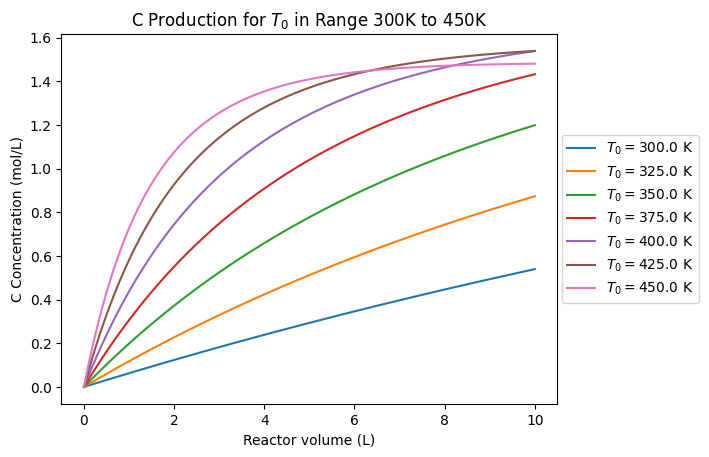

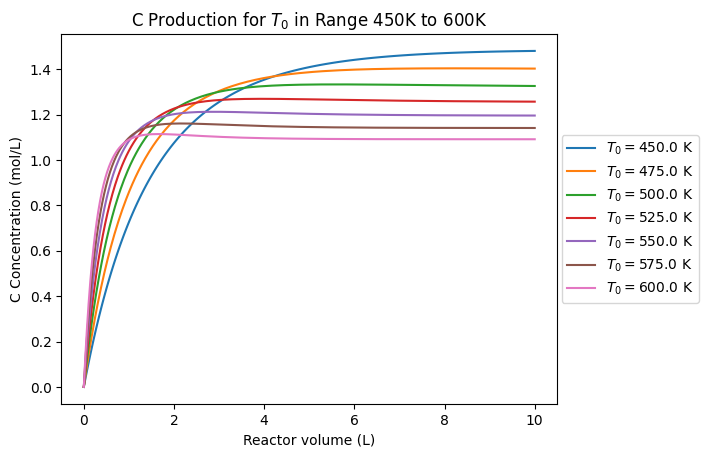

In [3]:
def p1_ode(t, y):
    f = y*0

    F_A = y[0]
    F_B = y[1]
    F_C = y[2]
    F_D = y[3]
    T = y[4]

    v_0 = 10
    C_PA = 20
    C_PB = C_PA
    C_PC = 60
    C_PD = 80
    H_1 = 20000
    H_2 = -10000

    k_1 = 0.001 * np.exp(5000 * 4.184 / 8.314 * (1 / 300 - 1 / T))
    k_2 = 0.001 * np.exp(7500 * 4.184 / 8.314 * (1 / 300 - 1 / T))

    r_1 = k_1 * F_A / v_0 * (F_B / v_0)**2
    r_2 = k_2 * F_A / v_0 * F_C / v_0

    f[0] = (-r_1 - r_2) * v_0
    f[1] = -2 * r_1 * v_0
    f[2] = (2 * r_1 - r_2) * v_0
    f[3] = 2 * r_2 * v_0
    f[4] = (r_1 * H_1 + r_2 * H_2) / (F_A * C_PA + F_B * C_PB + F_C * C_PC + F_D * C_PD)

    return f

ode_kwargs = {
    'method': 'Radau',
    'atol': 1e-8,
    'rtol': 1e-8,
} 

T_range = np.linspace(300, 600, 13)

p1_sols = []

for i, val in enumerate(T_range):
    ode_args = (
        p1_ode,
        [0, 10],
        [20, 40, 0, 0, val],
    )
    p1_sols.append(solve_ivp(*ode_args, **ode_kwargs))

for i in range(0, 7):
    plt.plot(p1_sols[i].t, p1_sols[i].y[2]/10, label=rf"$T_0=${T_range[i]} K")

plt.xlabel("Reactor volume (L)")
plt.ylabel("C Concentration (mol/L)")
plt.title(r"C Production for $T_0$ in Range 300K to 450K")
plt.legend(loc="right", bbox_to_anchor=(1.3, 0.5))
plt.show()

for i in range(6, len(p1_sols)):
    plt.plot(p1_sols[i].t, p1_sols[i].y[2]/10, label=rf"$T_0=${T_range[i]} K")

plt.xlabel("Reactor volume (L)")
plt.ylabel("C Concentration (mol/L)")
plt.title(r"C Production for $T_0$ in Range 450K to 600K")
plt.legend(loc="right", bbox_to_anchor=(1.3, 0.5))
plt.show()

An optimal inlet temperature is one between 400K and 425K. Reaction 1 is endothermic, and so a higher inlet temperature would allow it to produce more C. However, Reaction 2 has a high activation energy which means that it will be faster at higher temeperatures. Some intermediate temperature that is high enough to provide sufficient energy to Reaction 1 but not so high as to quickly make an undesirable product from Reaction 2 is the optimum.

# Problem 2

In [4]:
C_A = lambda X, p, T: 1.9 * (1 - X) / (1 - X / 2) * p * 450 / T
C_C = lambda X, p, T: 1.9 * (X) / (1 - X / 2) * p * 450 / T
dpdW = lambda X, p, T: -0.005 * (1 - X / 2) / 2 / p * T / 450
k = lambda T: 0.1 * np.exp(8000 / 8.314 *( 1 / 450 - 1 / T))
K = lambda T: 10000 * np.exp(-20000 / 8.314 * ( 1 / 450 - 1 / T))
r_A = lambda C_A, C_C, T: -k(T) * C_A**2 + k(T) / K(T) * C_C
F_A = lambda X: 5 * (1 - X)
F_C = lambda X: 5 * (X / 2)

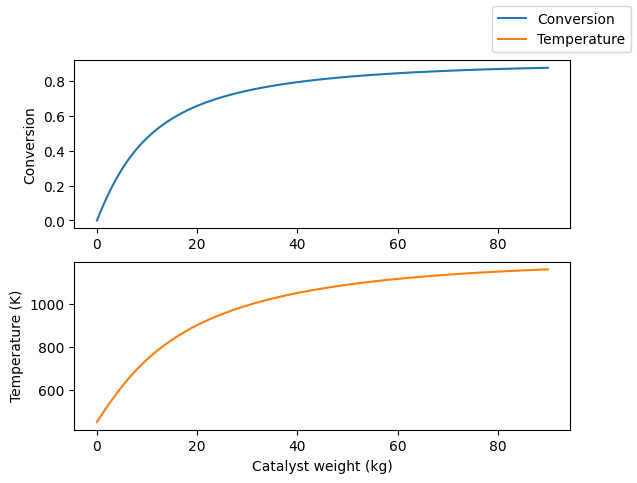

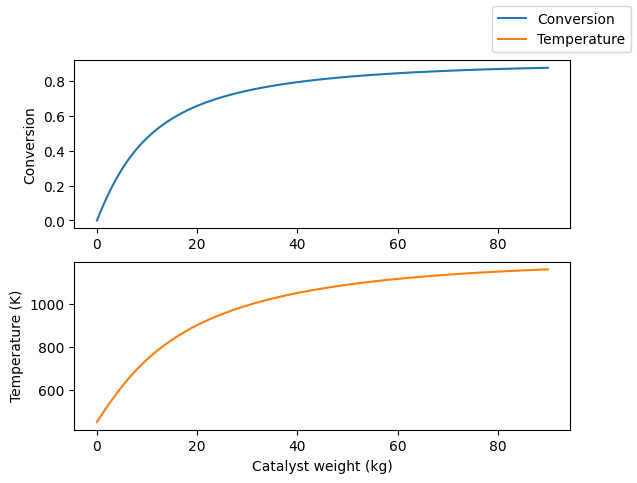

In [10]:
def p_2_adiabatic_ode(t, y):
    f = y*0

    X = y[0]
    p = y[1]
    T = y[2]

    f[0] = -r_A(C_A(X, p, T), C_C(X, p, T), T) / 5
    f[1] = dpdW(X, p, T)
    f[2] = -20000 * r_A(C_A(X, p, T), C_C(X, p, T), T) / (F_A(X) * 40 + F_C(X) * 20)

    return f

def p_2_const_T_a_ode(t, y):
    f = y*0

    X = y[0]
    p = y[1]
    T = y[2]

    r = r_A(C_A(X, p, T), C_C(X, p, T), T)

    f[0] = -r / 5
    f[1] = dpdW(X, p, T)
    f[2] = -20000 * r / (F_A(X) * 40 + F_C(X) * 20)

    return f

ode_args = (
    [0, 90],
    [0, 1, 450]
)

p2_sol = solve_ivp(p_2_adiabatic_ode, *ode_args, **ode_kwargs)

fig, ax = plt.subplots(2, figsize=[6.40, 4.80])
# fig, ax = plt.subplots(2, figsize=[6.40, 4.80*1.5])
ax[0].plot(p2_sol.t, p2_sol.y[0], 'tab:blue', label="Conversion")
ax[0].set_ylabel("Conversion")
ax[1].plot(p2_sol.t, p2_sol.y[2], 'tab:orange', label="Temperature")
ax[1].set_ylabel("Temperature (K)")
fig.legend()
plt.xlabel("Catalyst weight (kg)")
plt.show()

p2_sol = solve_ivp(p_2_adiabatic_ode, *ode_args, **ode_kwargs)

fig, ax = plt.subplots(2, figsize=[6.40, 4.80])
# fig, ax = plt.subplots(2, figsize=[6.40, 4.80*1.5])
ax[0].plot(p2_sol.t, p2_sol.y[0], 'tab:blue', label="Conversion")
ax[0].set_ylabel("Conversion")
ax[1].plot(p2_sol.t, p2_sol.y[2], 'tab:orange', label="Temperature")
ax[1].set_ylabel("Temperature (K)")
fig.legend()
plt.xlabel("Catalyst weight (kg)")
plt.show()

# Problem 3

Rate law:

$-r_A=k\frac{N_A}{V}$

Design equation:

$\frac{dN_A}{dt}=-r_AV=kN_A$

Analytical solution:

$\int\frac{dN_A}{N_A}=\int kdt$

$\ln\frac{N_A}{N_{A0}}=kt$

$N_A=N_{A0}e^{-kt}$

For $\frac{dT}{dt}=0$, energy balance must be $Q_g=Q_r$

$Q_g=r_AV\Delta H_{\text{rx}}^\circ=kN_{A0}e^{-kt}\Delta H_{\text{rx}}^\circ$

$Q_r=F_cC_{P,c}\left(T-T_0\right)$

$F_c=\frac{kN_{A0}e^{-kt}\Delta H_{\text{rx}}^\circ}{C_{P,c}\left(T-T_0\right)}$

At 2 h

$F_c=3.16$ lb/s